In [1]:
import sys, os
import tensorflow as tf
from keras import layers
from keras.models import Sequential
from keras import backend as K

Using TensorFlow backend.


In [3]:
K.set_learning_phase(1) #set learning phase
%pylab inline
%env CUDA_VISIBLE_DEVICES=0

sess = tf.InteractiveSession(config = tf.ConfigProto(gpu_options = tf.GPUOptions(allow_growth = True)))

Populating the interactive namespace from numpy and matplotlib
env: CUDA_VISIBLE_DEVICES=0


In [4]:
data = np.load('data/electrons_log', encoding='latin1')
real_data = np.exp(data)
tanh_data = np.tanh(real_data)

In [5]:
tanh_data.shape

(10000, 30, 30)

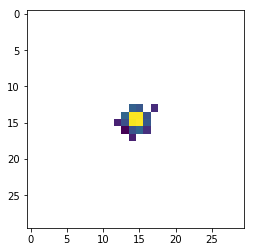

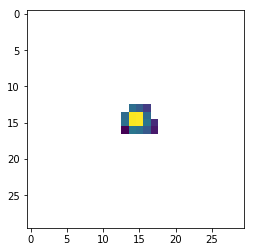

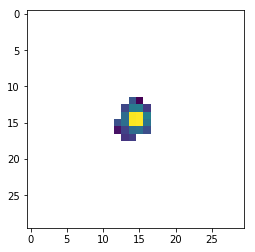

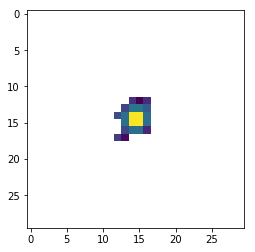

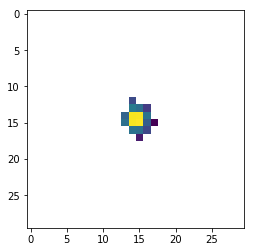

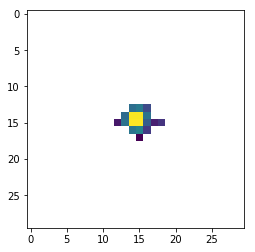

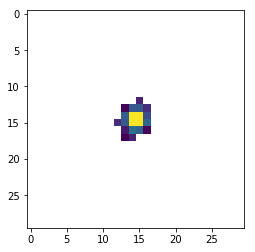

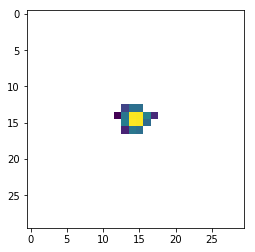

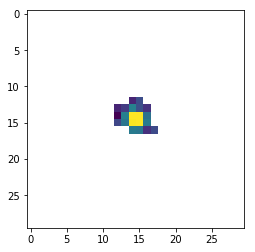

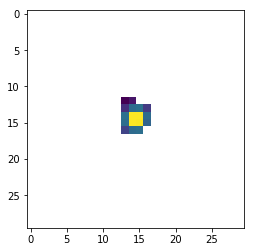

In [6]:
import scipy.misc
import matplotlib.pyplot as plt

%matplotlib inline

for i in range(10):
    plt.figure()
    plt.imshow(data[i])


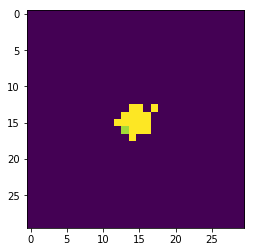

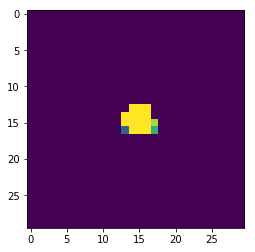

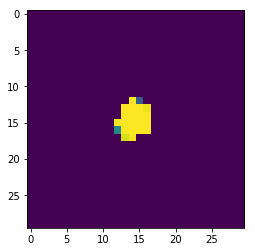

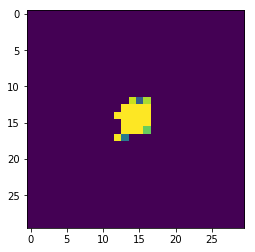

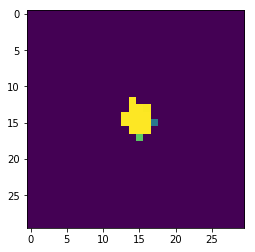

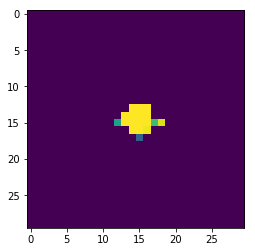

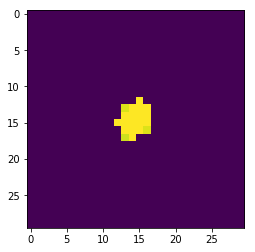

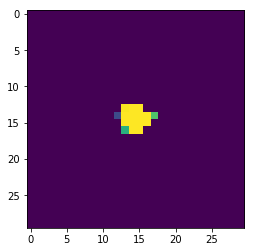

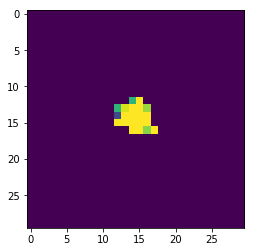

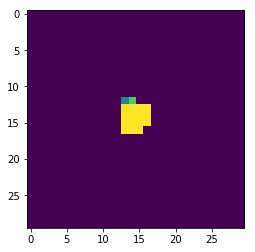

In [7]:
for i in range(10):
    plt.figure()
    plt.imshow(tanh_data[i])

# Исходные распределения

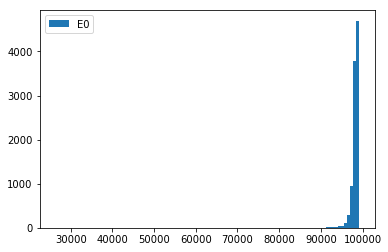

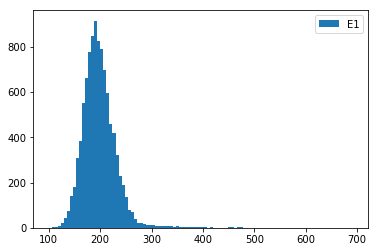

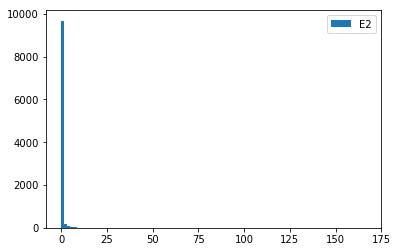

In [8]:
E, E_first, E_second = np.zeros(10000), np.zeros(10000), np.zeros(10000)

for i in range(10000):
    E[i] = np.exp(data[i][14][14]) +  np.exp(data[i][15][14]) + np.exp(data[i][14][15]) + np.exp(data[i][15][15])
    for j in range(4):
        for k in range(4):
            if (j == 0 or j == 3 or k == 0 or k == 3):
                 E_first[i] += np.exp(data[i][13+j][13+k])
            if (j == 0 or j == 7 or k == 0 or k == 7):
                 E_second[i] += np.exp(data[i][11+j][11+k])
                    
plt.hist(E, 100, label='E0')
plt.legend(loc='best')
plt.show()
plt.hist(E_first, 100, label='E1')
plt.legend(loc='best')
plt.show()
plt.hist(E_second, 100, label='E2')
plt.legend(loc='best')
plt.show()

## G

In [9]:
noise_shape = 100
img_shape = (30, 30, 1)
K.set_learning_phase(1)
leak_slope = 0.3

def build_generator_model(noise_shape):
    generator = Sequential()
    
    generator.add(layers.InputLayer(input_shape=[noise_shape]))
    generator.add(layers.Dense(10 * 10))
    generator.add(layers.Activation('relu'))
    generator.add(layers.Reshape((10, 10, 1)))
    generator.add(layers.Deconv2D(128 , kernel_size=5, activation='relu'))
    generator.add(layers.Deconv2D(64, kernel_size=4))
    generator.add(layers.Activation('relu'))
    generator.add(layers.Deconv2D(64, kernel_size=4, activation='relu'))
    generator.add(layers.Activation('relu'))
    generator.add(layers.Deconv2D(32, kernel_size=3, activation='relu'))
    generator.add(layers.Activation('relu'))
    generator.add(layers.Deconv2D(32, kernel_size=3, activation='relu'))
    generator.add(layers.Activation('relu'))
    generator.add(layers.Deconv2D(16, kernel_size=3, activation='relu'))
    generator.add(layers.Activation('relu'))
    generator.add(layers.Deconv2D(16, kernel_size=3, activation='relu'))
    generator.add(layers.Activation('relu'))
    generator.add(layers.Deconv2D(1, kernel_size=3, activation='tanh'))
    generator.summary()
    
    return generator

## D

In [10]:
def build_discriminator_model(img_shape):
    discriminator = Sequential()
    
    discriminator.add(layers.InputLayer(img_shape))
    discriminator.add(layers.Conv2D(32, kernel_size=4))
    discriminator.add(layers.LeakyReLU())
    discriminator.add(layers.Conv2D(32, kernel_size=4))
    discriminator.add(layers.LeakyReLU())
    discriminator.add(layers.AveragePooling2D(pool_size=2))
    discriminator.add(layers.Conv2D(32, kernel_size=4))
    discriminator.add(layers.LeakyReLU())
    discriminator.add(layers.Conv2D(64, kernel_size=3))
    discriminator.add(layers.LeakyReLU())
    discriminator.add(layers.Conv2D(64, kernel_size=3))
    discriminator.add(layers.LeakyReLU())
    discriminator.add(layers.AveragePooling2D(pool_size=2))
    discriminator.add(layers.Conv2D(128, kernel_size=1))
    discriminator.add(layers.LeakyReLU())
    discriminator.add(layers.Flatten())
    discriminator.add(layers.Dense(256))
    discriminator.add(layers.Activation('tanh'))
    discriminator.add(layers.Dense(2, activation=tf.nn.log_softmax))
    discriminator.summary()
    
    return discriminator

generator = build_generator_model(noise_shape)
discriminator = build_discriminator_model(img_shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 10, 10, 1)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       3328      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 17, 17, 64)        131136    
_________________________________________________________________
activation_2 (Activation)    (None, 17, 17, 64)        0         
__________

In [11]:
real_data_mean = real_data.mean(axis=0)
real_data_std = real_data.std(axis=0)
stand_real_data = np.divide(real_data - real_data_mean, real_data_std, where= (real_data - real_data_mean) != 0)

In [12]:
noise = tf.placeholder(tf.float32, [None, noise_shape])
real_data = tf.placeholder(tf.float32, [None,] + list(img_shape))

discriminated_real_data = discriminator(real_data)
generated_data = generator(noise)

discriminated_generated_data = discriminator(generated_data)

########################
#discriminator training#
########################
discriminator_loss = -tf.reduce_mean(discriminated_generated_data[:, 0] + discriminated_real_data[:, 1])
discriminator_loss += tf.reduce_mean(np.abs(discriminator.layers[-1].kernel))

discriminator_optimize = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5, beta2=0.9) \
                                .minimize(discriminator_loss, var_list=discriminator.trainable_weights)

########################
###generator training###
########################
generator_loss = -tf.reduce_mean(discriminated_generated_data[:, 1])

generator_optimizer = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5, beta2=0.9) \
                                .minimize(generator_loss, var_list = generator.trainable_weights)

sess.run(tf.global_variables_initializer())

In [13]:
data = stand_real_data

def save_models():
    now = datetime.datetime.now().isoformat().split('T')[0]
    generator.save("upgrade_gen_model+{}+bn.h5".format(now))
    discriminator.save("upgrade_dis_model+{}+bn.h5".format(now))

def sample_noise_batch(bsize):
    noise = np.random.normal(size=(bsize, noise_shape)).astype('float32') 
    return noise

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs].reshape((-1, 30, 30, 1))

def sample_images(nrow,ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            print(images[i].shape)
            plt.imshow(images[i].reshape(30,30), interpolation="none")
        else:
            plt.imshow(images[i].reshape(30,30))
    plt.show()
    return images

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()
    
def sample_many_images(how_many):
    images = generator.predict(sample_noise_batch(bsize=how_many)).reshape(-1, 30, 30)
    return images

epoch 2500
(30, 30, 1)


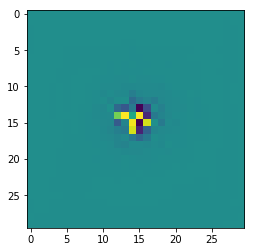

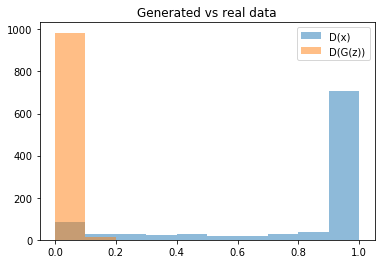

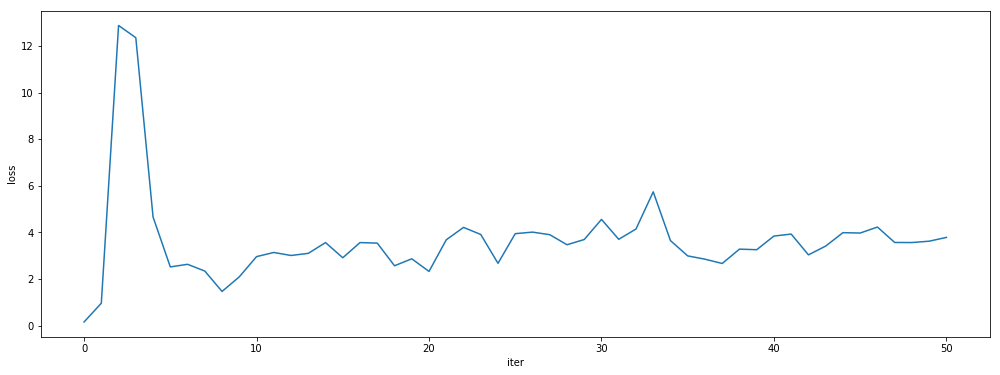

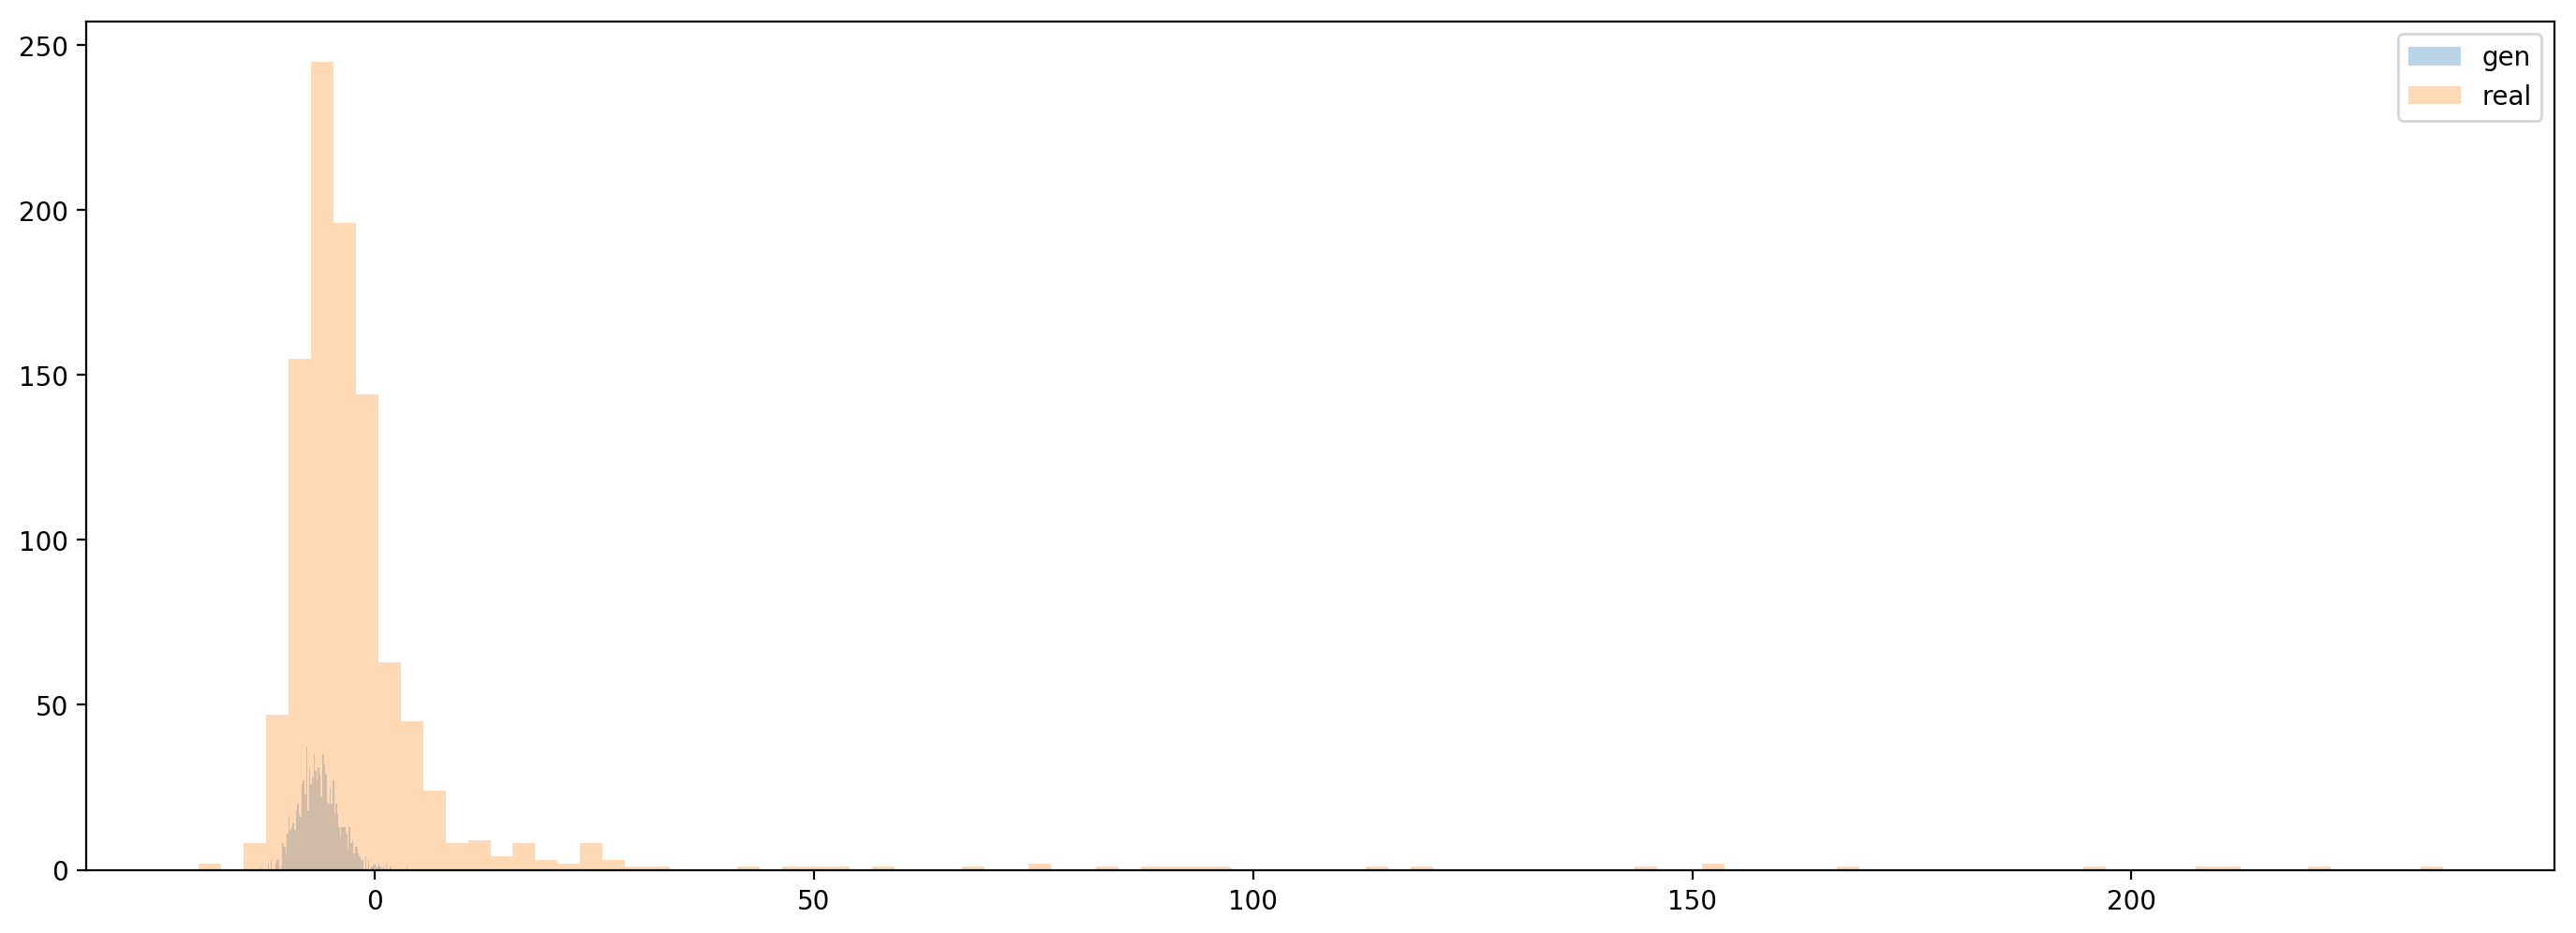

KeyboardInterrupt: 

In [14]:
from IPython import display

loss_list = []
prev_img = generator.predict(sample_noise_batch(1))[0, :, :, 0]
for epoch in range(10000):
    
    feed_dict = {
        real_data : sample_data_batch(100),
        noise : sample_noise_batch(100)
    }
    
    for i in range(4):
        sess.run(discriminator_optimize, feed_dict)
    
    sess.run(generator_optimizer, feed_dict)
    
    if epoch % 50 == 0:
        display.clear_output()
        print("epoch", epoch)
        sample_images(1,1,True)
        sample_probas(1000)
        save_models()
        
        new_img = generator.predict(sample_noise_batch(1))[0, :, :, 0]
        diff = np.linalg.norm(prev_img - new_img)
        prev_img = new_img
        loss_list.append(diff)
        
        plt.figure(figsize=(17, 6))
        plt.xlabel('iter')
        plt.ylabel('loss')
        plt.plot(loss_list)
        
        sample_imgs = sample_many_images(1000)
        
        plt.figure(figsize=(17, 6), dpi=200)
        _ = plt.hist(sample_imgs.sum(axis=(1, 2)), bins=100, alpha=.3, label='gen')
        _ = plt.hist(data[:1000].sum(axis=(1, 2)), bins=100, alpha=.3, label='real')
        plt.legend()
        plt.show()

In [15]:
sample_imgs = sample_many_images(5000)
arc_sample_imgs = np.arctanh(sample_imgs)
real_sample_img = arc_sample_imgs * real_data_std + real_data_mean

central_2 = np.sum(real_sample_img[:, 14:16, 14:16], axis=(1, 2))
    
mask_4_2 = np.zeros((30, 30), dtype=bool)
mask_4_2[13:17, [13, 16]] = True
mask_4_2[[13, 16], 13:17] = True
    
central_4_2 = np.sum(real_sample_img[:, mask_4_2], axis=1)
    
mask_6_4 = np.zeros((30, 30), dtype=bool)
mask_6_4[12:18, [12, 17]] = True
mask_6_4[[12, 17], 12:18] = True
    
central_6_4 = np.sum(real_sample_img[:, mask_6_4], axis=1)

/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in arctanh
  


# Сравнение распределений

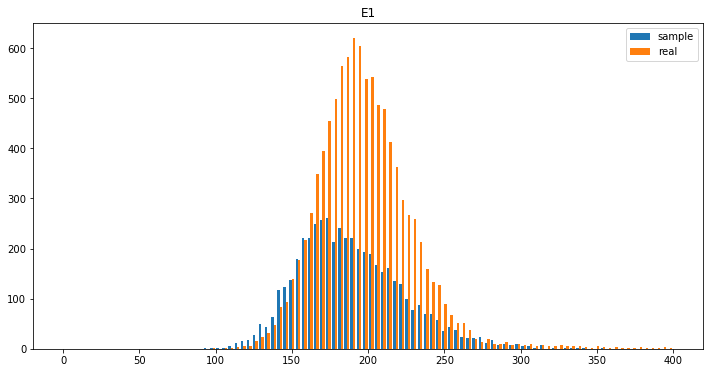

In [51]:
plt.figure(figsize=(12,6))
plt.title('E1')
plt.hist([central_4_2, E_first], bins=100, label=['sample', 'real'], range=(0, 400))
plt.legend(loc='best')
plt.show()

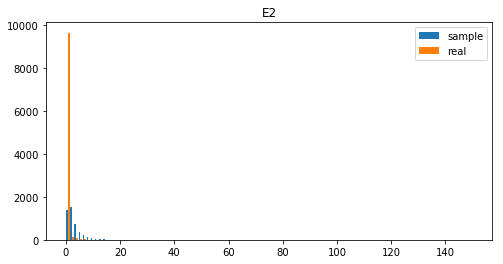

In [49]:
plt.figure(figsize=(8,4))
plt.title('E2')
plt.hist([central_6_4, E_second], bins=100, label=['sample', 'real'], range=(0, 30))
plt.legend(loc='best')
plt.show()

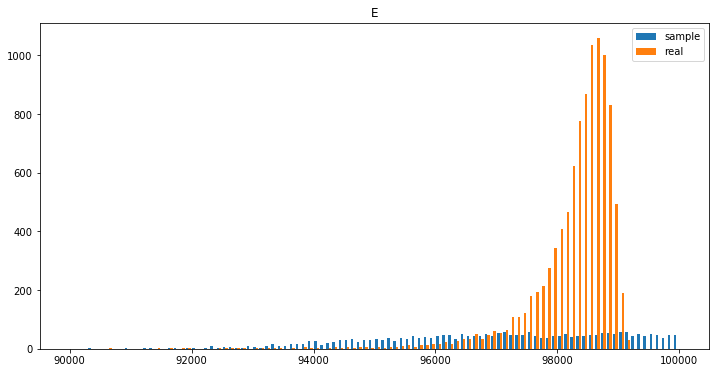

In [48]:
plt.figure(figsize=(12,6))
plt.title('E')
plt.hist([central_2, E], bins=100, label=['sample', 'real'], range=(90000, 100000))
plt.legend(loc='best')
plt.show()